In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Extracting the Train-Val-Test Data
import pickle
fp = "/content/drive/My Drive/BT4222 Group Project/Final Project/Codes/Jar of Pickles/train_val_test_data.pkl"
with open(fp,"rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(file=f)

print(len(X_train))
print(y_train.shape)
print(len(X_val))
print(y_val.shape)
print(len(X_test))
print(y_test.shape)

17843
(17843, 2)
4461
(4461, 2)
2479
(2479, 2)


## 5. Solution 2: Predicting

Prediction Models Used in this File:
<br>5.1 Bert
<br>5.2 XGBoost
<br>5.3 Multinomial Naive Bayes
<br>5.4 Log Regression

### Data Representation

#### Count Vectorizer

In [3]:
### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

#### Tf-idf Vectorizer

In [4]:
### Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_basic = TfidfVectorizer()
tfidf_vect_norm = TfidfVectorizer(norm=None)
tfidf_vect_norm_stopwords = TfidfVectorizer(norm=None,stop_words='english')
tfidf_vect_norm_stopwords_ngram = TfidfVectorizer(norm=None,stop_words='english',
                                                  ngram_range=(1, 2))
tfidf_vect_norm_stopwords_ngram_maxdf = TfidfVectorizer(norm=None,stop_words='english',
                                                  ngram_range=(1, 2), max_df= 0.7)

### 5.1 BERT (done)

#### BERT: Package Downloads

In [5]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 28.2 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 895 kB 76.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#### BERT: Customer Functions

In [7]:
### Define Custom Functions
import tensorflow as tf

# custom callback for performance metric: mean column wise AUC
class CustomMetrics(tf.keras.callbacks.Callback):

    def __init__(self,train_data,train_labels,val_data,val_labels):
        '''
        This function initializes callback object to 
        compute custom metric
        '''
        
        self.train_data = train_data
        self.train_labels = train_labels
        self.val_data = val_data
        self.val_labels = val_labels
    
    def on_epoch_end(self,epoch,logs={}):
        '''
        This function computes the mean wise column AUC at 
        the end of each epoch
        '''
        
        # predicting probabilities for training datapoints
        train_proba = self.model.predict(self.train_data)
        
        # mean column wise auc for train set
        train_auc = roc_auc_score(y_true=self.train_labels,
                                  y_score=train_proba,
                                  average="macro")
        
        # predicting probabilities for val datapoints
        val_proba = self.model.predict(self.val_data)
        
        # mean column wise auc for val set
        val_auc = roc_auc_score(y_true=self.val_labels,
                                  y_score=val_proba,
                                  average="macro")
        
        print(f"train_auc: {round(train_auc,4)} val_auc: {round(val_auc,4)}")


# custom callback to save model after each epoch
class SaveModel(tf.keras.callbacks.Callback):

    def __init__(self,file_path):
        '''
        This function initializes callback object to 
        save model
        '''
        self.file_path = file_path
    
    def on_epoch_end(self,epoch,logs={}):
        '''
        Function saves model architecture, weights and optimizer state for current epoch
        '''

        # saving the model to specified file location
        self.model.save(self.file_path)


def load_embeddings(embedding_type):
    '''
    Function to load embeddings based on input type specified
    '''

    # creating file path
    fp = f"/content/drive/My Drive/Project/{embedding_type}_embedding_matrix.pkl"

    # loading embedding matrix
    with open(fp,mode="rb") as f:
      embedding_matrix = pickle.load(file=f)

    return embedding_matrix


def get_test_predictions(test_data,model_type):
    '''
    Function returns predictions of test data set by using input model specified
    '''

    # model file path
    fp = f"models/{model_type}.hdf5"

    # loading the model
    model = tf.keras.models.load_model(fp)

    # predicting class probabilities
    pred_proba = model.predict(test_data)

    # dataframe to store results
    pred_df = pd.DataFrame()

    

    # adding predicted probability for each class
    class_labels = ["neutral","hate"]
    for i,label in enumerate(class_labels):
      pred_df[label] = pred_proba[:,i]

    
    # filepath to save predictions
    fp = f"/content/drive/My Drive/Project/predictions/{model_type}.csv"

    # saving to disk
    pred_df.to_csv(fp)

    print("Predictions saved to disk")

#### BERT: Modelling

In [9]:
from transformers import AutoTokenizer, TFAutoModel # for BERT implementation
from sklearn import metrics
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
import numpy as np
# define function to handle tokenization as BERT requires special embeddings
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# create tensor datasets for input ids, attention masks & labels
def create_tensorDataset(X, y, SEQ_LEN):
  X_ids = np.zeros((len(X), SEQ_LEN))
  X_mask = np.zeros((len(X), SEQ_LEN))

  # loop through data and tokenize everything
  for id, sentence in enumerate(X):
      X_ids[id, :], X_mask[id, :] = tokenize(sentence)

  # create tensor slices
  dataset = tf.data.Dataset.from_tensor_slices((X_ids, X_mask, y))

  # apply the mapping function to the dataset
  dataset = dataset.map(map_func)

  # batch the dataset(16 or 32 is ideal for BERT)
  dataset = dataset.batch(32)

  # iterate through dataset obj and fill up the tensor arrays
  # we've already split the dataset into train, val & test, so here we will take all rows of the X passed in
  dataset = dataset.take(X_ids.shape[0]) 
  
  return dataset

# map ids, masks & labels 
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [11]:
# Set max sequence length for a sentence
SEQ_LEN = 15 # to try: 15

# Output tensor datasets for train, val & test set
train = create_tensorDataset(X_train, y_train, SEQ_LEN)
val = create_tensorDataset(X_val, y_val, SEQ_LEN)
test = create_tensorDataset(X_test, y_test, SEQ_LEN)

In [15]:
# build the model
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(X)  # adjust based on number of sentiment classes

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer
model.layers[2].trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 15)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 15)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 768)         0           ['tf_bert_model[1][0]']    

In [33]:
# defining callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, confusion_matrix

# filepath to save model
filepath = "bert.hdf5"

custom_metric = CustomMetrics(train_data=train,
                              train_labels=y_train,
                              val_data=val,
                              val_labels=y_val)
early_stop = EarlyStopping(monitor="val_loss",
                           patience=3,
                           verbose=1)
save_model = SaveModel(file_path=filepath)

# adding callbacks to single list
callbacks = [custom_metric,early_stop,save_model]

In [19]:
# compile the model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy')

# and train it
model.fit(train, validation_data=val, epochs=10, callbacks=callbacks)

Epoch 1/10
558/558 [==============================] - 77s 119ms/step - loss: 0.2625 - val_loss: 0.2330
Epoch 2/10
558/558 [==============================] - 62s 110ms/step - loss: 0.2418 - val_loss: 0.2813
Epoch 3/10
558/558 [==============================] - 62s 112ms/step - loss: 0.2393 - val_loss: 0.2208
Epoch 4/10
558/558 [==============================] - 62s 111ms/step - loss: 0.2385 - val_loss: 0.2328
Epoch 5/10
558/558 [==============================] - 62s 111ms/step - loss: 0.2357 - val_loss: 0.2421
Epoch 6/10
558/558 [==============================] - 62s 111ms/step - loss: 0.2278 - val_loss: 0.2498
Epoch 6: early stopping


In [20]:
fp = "/content/drive/My Drive/BT4222 Group Project/Final Project/Codes/Models/bert"
model.save(fp)

INFO:tensorflow:Assets written to: /content/drive/My Drive/BT4222 Group Project/Final Project/Codes/Models/bert/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/BT4222 Group Project/Final Project/Codes/Models/bert/assets


In [36]:
bert_test_auc = roc_auc_score(y_true=y_test,
                                  y_score=model.predict(test),
                                  average="macro")
print(bert_test_auc)

0.9334907737984265


In [39]:
bert_train_auc = roc_auc_score(y_true=y_train,
                                  y_score=model.predict(train),
                                  average="macro")
print(bert_train_auc)

bert_val_auc = roc_auc_score(y_true=y_val,
                                  y_score=model.predict(val),
                                  average="macro")
print(bert_train_auc)

0.9561431770725786
0.9561431770725786


### 5.2 XGBoost

In [ ]:
import xgboost as xg
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
# Extracting data suitable for XGBoost
X_train_xg = X_train
y_train_xg = y_train[:,1] # 0 = neutral, 1 = hate
X_val_xg = X_val
y_val_xg = y_val[:,1]
X_test_xg = X_test
y_test_xg = y_test[:,1]

def tokenize_test_xgb(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)

    print(X_train_dtm.shape)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use XGBClassifier
    xgb = xg.sklearn.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=12,
                                    min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
                                    objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=True, subsample=1)
    
    model = xgb.fit(X_train_dtm, y_train_xg)
    y_pred_class = xgb.predict(X_val_dtm)
    y_pred_proba = xgb.predict_proba(X_val_dtm)
    
    #classification report
    #print(classification_report(y_val,y_pred_class))
    
    # print accuracy.precision of its predictions
    print('Accuracy: ', metrics.accuracy_score(y_val_xg, y_pred_class))
    print('Precision: ', metrics.precision_score(y_val_xg, y_pred_class))
    print('Recall: ', metrics.recall_score(y_val_xg, y_pred_class))
    print('ROC AUC: ', metrics.roc_auc_score(y_val_xg,y_pred_proba[:,1]))
    print('Confusion Matrix: ', confusion_matrix(y_val_xg, y_pred_class))

    #Tree diagram
    plot_tree(model)
    plt.show()

In [ ]:
y_val_xg.shape

(4461,)

In [ ]:
len(X_train_xg)

17843

In [ ]:
y_train_xg.shape

(17843,)

In [ ]:
tokenize_test_xgb(count_vect, X_train_xg, y_train_xg, X_val_xg, y_val_xg)

(17843, 16980)
Features:  16980
Accuracy:  0.9509078681909886
Precision:  0.9794125720559979
ROC AUC:  0.9809606055200036
Confusion Matrix:  [[ 674   75]
 [ 144 3568]]


In [ ]:
tokenize_test_xgb(tfidf_vect_basic, X_train_xg, y_train_xg, X_val_xg, y_val_xg)

In [ ]:
tokenize_test_xgb(count_vect, X_train_xg, y_train_xg, X_val_xg, y_val_xg)
tokenize_test_xgb(tfidf_vect_basic, X_train_xg, y_train_xg, X_val_xg, y_val_xg)
tokenize_test_xgb(tfidf_vect_norm, X_train_xg, y_train_xg, X_val_xg, y_val_xg)
tokenize_test_xgb(tfidf_vect_norm_stopwords, X_train_xg, y_train_xg, X_val_xg, y_val_xg)
tokenize_test_xgb(tfidf_vect_norm_stopwords_ngram, X_train_xg, y_train_xg, X_val_xg, y_val_xg)
tokenize_test_xgb(tfidf_vect_norm_stopwords_ngram_maxdf,X_train_xg, y_train_xg, X_val_xg, y_val_xg)

In [ ]:
from prettytable import PrettyTable

# creating table object
table = PrettyTable(field_names=["Data Representation","Val ROC_AUC"])

# adding rows
table.add_row(["Count Vectorizer",0.9816])
table.add_row(["Tf-idf",0.9791])
table.add_row(["Tf-idf, norm = None",0.9816])
table.add_row(["Tf-idf, norm = None, stopword = english",0.9814])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2)",0.9815])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7",0.9815])
print(table)

+----------------------------------------------------------------------+-------------+
|                         Data Representation                          | Val ROC_AUC |
+----------------------------------------------------------------------+-------------+
|                           Count Vectorizer                           |    0.9816   |
|                                Tf-idf                                |    0.9791   |
|                         Tf-idf, norm = None                          |    0.9816   |
|               Tf-idf, norm = None, stopword = english                |    0.9814   |
|        Tf-idf, norm = None, stopword = english, ngram = (1,2)        |    0.9815   |
| Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7 |    0.9815   |
+----------------------------------------------------------------------+-------------+


(17843, 92695)
Features:  92695
Accuracy:  0.9513561981618471
Precision:  0.9796870710952512
Recall:  0.9614762931034483
ROC AUC:  0.9815261944086369
Confusion Matrix:  [[ 675   74]
 [ 143 3569]]


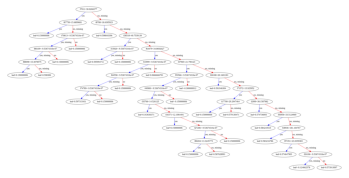

In [ ]:
### Apply on Test Set
tokenize_test_xgb(tfidf_vect_norm_stopwords_ngram, X_train_xg, y_train_xg, X_test_xg, y_test_xg)

In [ ]:
# creating table object
table = PrettyTable(field_names=["Tf-idf Model (norm = None, stopword = english, ngram = (1,2)","Test Set Performance"])

# adding rows
table.add_row(["Accuracy",0.9513])
table.add_row(["Precision",0.9796])
table.add_row(["Recall",0.9614])
table.add_row(["ROC_AUC",0.9815])
print(table)

+--------------------------------------------------------------+----------------------+
| Tf-idf Model (norm = None, stopword = english, ngram = (1,2) | Test Set Performance |
+--------------------------------------------------------------+----------------------+
|                           Accuracy                           |        0.9513        |
|                          Precision                           |        0.9796        |
|                            Recall                            |        0.9614        |
|                           ROC_AUC                            |        0.9815        |
+--------------------------------------------------------------+----------------------+


### 5.3 Multinomial NB (done)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Extracting data suitable for NB
X_train_nb = X_train
y_train_nb = y_train[:,1] # 0 = neutral, 1 = hate
X_val_nb = X_val
y_val_nb = y_val[:,1]
X_test_nb = X_test
y_test_nb = y_test[:,1]

# define a NB function that accepts a vectorizer and calculates the accuracy
def tokenize_test_nb(vect, X_train, y_train, X_val, y_val):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict the class labels of tweets
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_val_dtm)
    nb_pred_class = nb.predict(X_val_dtm) # gives specific class: 0/1
    nb_pred_proba = nb.predict_proba(X_val_dtm) # gives a list for each point [P(0), P(1)]
    
    # ACCURACY
    print('Accuracy: ', metrics.accuracy_score(y_val, nb_pred_class))
    
    # PRECISION
    print('Precision: ', metrics.precision_score(y_val, nb_pred_class))
        
    # RECALL 
    print('Recall: ', metrics.recall_score(y_val, nb_pred_class))
        
    # ROC_AUC
    print('roc_auc: ', metrics.roc_auc_score(y_val, nb_pred_proba[:,1]))

    #Confusion Matrix
    #print('----')
    #print('Tes confusion_matrix: ', metrics.confusion_matrix(y_val, nb_pred_class))


In [ ]:
# Testing different Representations
print("> Count Vectorizer: ")
tokenize_test_nb(count_vect, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [no hyperparameter tuning]: ")
tokenize_test_nb(tfidf_vect_basic, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None]: ")
tokenize_test_nb(tfidf_vect_norm, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram_maxdf, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

> Count Vectorizer: 
Features:  16980
Accuracy:  0.9222147500560413
Precision:  0.9260572296783995
Recall:  0.9851831896551724
roc_auc:  0.9721266286082594
> Tf-idf Vectorizer [no hyperparameter tuning]: 
Features:  16980
Accuracy:  0.8601210490921318
Precision:  0.8570767807585569
Recall:  0.9983836206896551
roc_auc:  0.9554738573845587
> Tf-idf Vectorizer [norm = None]: 
Features:  16980
Accuracy:  0.9027123963236943
Precision:  0.9401181525241675
Recall:  0.9431573275862069
roc_auc:  0.9080564675314213
> Tf-idf Vectorizer [norm = None, stopword = english]: 
Features:  16849
Accuracy:  0.9027123963236943
Precision:  0.9401181525241675
Recall:  0.9431573275862069
roc_auc:  0.9083548179181438
> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: 
Features:  92695
Accuracy:  0.9143689755660166
Precision:  0.9461414790996785
Recall:  0.951239224137931
roc_auc:  0.9155787098314995
> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: 
Features

In [ ]:
from prettytable import PrettyTable

# creating table object
table = PrettyTable(field_names=["Model","Val ROC_AUC"])

# adding rows
table.add_row(["Count Vectorizer",0.9721])
table.add_row(["Tf-idf",0.9554])
table.add_row(["Tf-idf, norm = None",0.9080])
table.add_row(["Tf-idf, norm = None, stopword = english",0.9083])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2)",0.9155])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7",0.9155])
print(table)

+----------------------------------------------------------------------+-------------+
|                                Model                                 | Val ROC_AUC |
+----------------------------------------------------------------------+-------------+
|                           Count Vectorizer                           |    0.9721   |
|                                Tf-idf                                |    0.9554   |
|                         Tf-idf, norm = None                          |    0.908    |
|               Tf-idf, norm = None, stopword = english                |    0.9083   |
|        Tf-idf, norm = None, stopword = english, ngram = (1,2)        |    0.9155   |
| Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7 |    0.9155   |
+----------------------------------------------------------------------+-------------+


In [ ]:
### Apply on Test Set
tokenize_test_nb(count_vect, X_train_nb, y_train_nb, X_test_nb, y_test_nb)

Features:  16980
Accuracy:  0.9221460266236385
Precision:  0.9269406392694064
Recall:  0.9840038778477945
roc_auc:  0.9711107330623812


In [ ]:
# creating table object
table = PrettyTable(field_names=["Count Vectorizer Model","Test Set Performance"])

# adding rows
table.add_row(["Accuracy",0.9221])
table.add_row(["Precision",0.9269])
table.add_row(["Recall",0.9840])
table.add_row(["ROC_AUC",0.9711])
print(table)

+------------------------+----------------------+
| Count Vectorizer Model | Test Set Performance |
+------------------------+----------------------+
|        Accuracy        |        0.9221        |
|       Precision        |        0.9269        |
|         Recall         |        0.984         |
|        ROC_AUC         |        0.9711        |
+------------------------+----------------------+


### 5.4 Logistic Regression (done)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Extracting data suitable for LR
X_train_lr = X_train
y_train_lr = y_train[:,1] # 0 = neutral, 1 = hate
X_val_lr = X_val
y_val_lr = y_val[:,1]
X_test_lr = X_test
y_test_lr = y_test[:,1]

# define a NB function that accepts a vectorizer and calculates the accuracy
def tokenize_test_lr(vect, X_train, y_train, X_val, y_val):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Logistic Regression to predict the class labels of tweets
    # Regularization at 0.01, solver stochastic gradient , iterate for 500 epochs
    lr = LogisticRegression(C=100,solver='sag',max_iter=500)
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_val_dtm)
    lr_pred_class = lr.predict(X_val_dtm) # gives specific class: 0/1
    lr_pred_proba = lr.predict_proba(X_val_dtm) # gives a list for each point [P(0), P(1)]

    
    # ACCURACY
    print('Accuracy: ', metrics.accuracy_score(y_val, lr_pred_class))
    
    # PRECISION
    print('Precision: ', metrics.precision_score(y_val, lr_pred_class))
        
    # RECALL 
    print('Recall: ', metrics.recall_score(y_val, lr_pred_class))
        
    # ROC_AUC
    print('roc_auc: ', metrics.roc_auc_score(y_val, lr_pred_proba[:,1]))

    #Confusion Matrix
    #print('----')
    #print('Test confusion_matrix: ', metrics.confusion_matrix(y_val, lr_pred_class))

In [ ]:
# Testing different Representations
print("> Count Vectorizer: ")
tokenize_test_lr(count_vect, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [no hyperparameter tuning]: ")
tokenize_test_lr(tfidf_vect_basic, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None]: ")
tokenize_test_lr(tfidf_vect_norm, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None, stopword = english]: ")
tokenize_test_lr(tfidf_vect_norm_stopwords, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: ")
tokenize_test_lr(tfidf_vect_norm_stopwords_ngram, X_train_lr, y_train_lr, X_val_lr, y_val_lr)
print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: ")
tokenize_test_lr(tfidf_vect_norm_stopwords_ngram_maxdf, X_train_lr, y_train_lr, X_val_lr, y_val_lr)


> Count Vectorizer: 
Features:  16980


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy:  0.9527011880744227
Precision:  0.9729802756011888
Recall:  0.9700969827586207
roc_auc:  0.9773974854403573
> Tf-idf Vectorizer [no hyperparameter tuning]: 
Features:  16980
Accuracy:  0.9455279085406859
Precision:  0.9651381067310271
Recall:  0.9695581896551724
roc_auc:  0.9769597610031767
> Tf-idf Vectorizer [norm = None]: 
Features:  16980


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy:  0.9497870432638422
Precision:  0.9680622651637144
Recall:  0.9717133620689655
roc_auc:  0.9747121521223701
> Tf-idf Vectorizer [norm = None, stopword = english]: 
Features:  16849


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy:  0.9491145483075544
Precision:  0.9682880945982263
Recall:  0.970635775862069
roc_auc:  0.9748186159131714
> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: 
Features:  92695


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Accuracy:  0.9522528581035642
Precision:  0.9686579158853469
Recall:  0.9741379310344828
roc_auc:  0.9801533150522536
> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: 
Features:  92695
Accuracy:  0.9522528581035642
Precision:  0.9689091396408469
Recall:  0.9738685344827587
roc_auc:  0.9801367700036832


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# creating table object
table = PrettyTable(field_names=["Model","Val ROC_AUC"])

# adding rows
table.add_row(["Count Vectorizer",0.9773])
table.add_row(["Tf-idf",0.9769])
table.add_row(["Tf-idf, norm = None",0.9747])
table.add_row(["Tf-idf, norm = None, stopword = english",0.9748])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2)",0.9801])
table.add_row(["Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7",0.9801])
print(table)

+----------------------------------------------------------------------+-------------+
|                                Model                                 | Val ROC_AUC |
+----------------------------------------------------------------------+-------------+
|                           Count Vectorizer                           |    0.9773   |
|                                Tf-idf                                |    0.9769   |
|                         Tf-idf, norm = None                          |    0.9747   |
|               Tf-idf, norm = None, stopword = english                |    0.9748   |
|        Tf-idf, norm = None, stopword = english, ngram = (1,2)        |    0.9801   |
| Tf-idf, norm = None, stopword = english, ngram = (1,2), max_df = 0.7 |    0.9801   |
+----------------------------------------------------------------------+-------------+


In [ ]:
### Apply on Test Set
tokenize_test_lr(tfidf_vect_norm_stopwords_ngram, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Features:  92695
Accuracy:  0.9511899959661154
Precision:  0.965484180249281
Recall:  0.9762481822588464
roc_auc:  0.982977320183452


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# creating table object
table = PrettyTable(field_names=["Tf-idf, norm = None, stopword = english, ngram = (1,2)","Test Set Performance"])

# adding rows
table.add_row(["Accuracy",0.9551])
table.add_row(["Precision",0.9654])
table.add_row(["Recall",0.9762])
table.add_row(["ROC_AUC",0.9821])
print(table)

+--------------------------------------------------------+----------------------+
| Tf-idf, norm = None, stopword = english, ngram = (1,2) | Test Set Performance |
+--------------------------------------------------------+----------------------+
|                        Accuracy                        |        0.9551        |
|                       Precision                        |        0.9654        |
|                         Recall                         |        0.9762        |
|                        ROC_AUC                         |        0.9821        |
+--------------------------------------------------------+----------------------+
